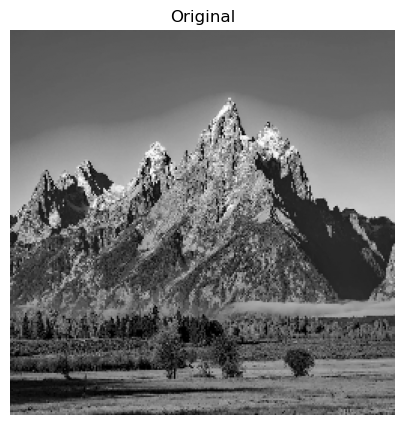

In [1]:
# %%
#  Wiener filtering (a) constant ratio and (b) autocorrelation/PSD-based

import cv2
import numpy as np
import matplotlib.pyplot as plt

# ---------- Load a clean image (we will synthetically degrade it) ----------
img_path = "../image2.jpg"   # <--- change if needed
orig = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if orig is None:
    raise FileNotFoundError(img_path)

H, W = 256, 256
orig = cv2.resize(orig, (W, H)).astype(np.float32)

plt.figure(figsize=(5,5))
plt.imshow(orig, cmap="gray"); plt.title("Original"); plt.axis("off"); plt.show()


In [2]:
# %%
# ---------- FFT helpers ----------
def fft2c(im):
    F  = np.fft.fft2(im)
    return np.fft.fftshift(F)

def ifft2c(Fc):
    F  = np.fft.ifftshift(Fc)
    return np.fft.ifft2(F).real

def show(im, title="", s=5, cmap="gray"):
    plt.figure(figsize=(s,s))
    plt.imshow(im, cmap=cmap); plt.title(title); plt.axis("off"); plt.show()

def magspec(X):
    return np.log1p(np.abs(X))


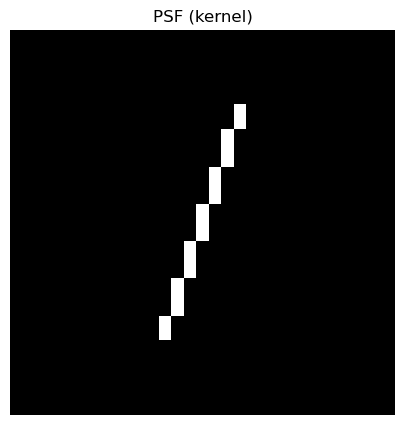

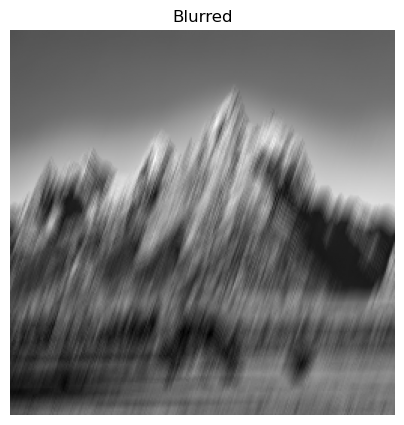

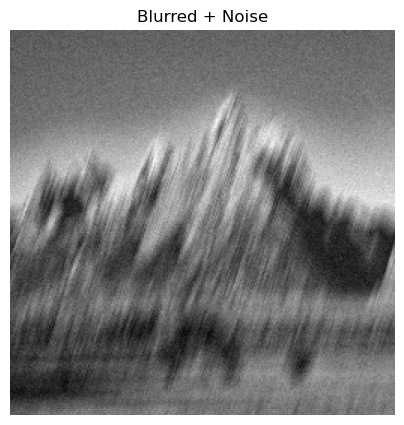

In [3]:
# %%
# ---------- PSFs (blur models) ----------
def psf_motion(size, length=21, angle=25):
    PSF = np.zeros((size, size), np.float32)
    c = size//2
    cv2.ellipse(PSF, (c, c), (0, length//2), angle, 0, 360, 1, -1)
    PSF /= PSF.sum() + 1e-8
    return PSF

def psf_gaussian(size, sigma=3.0):
    k = cv2.getGaussianKernel(size, sigma)
    PSF = k @ k.T
    PSF /= PSF.sum()
    return PSF

# Choose ONE PSF
psf_size = 31
PSF = psf_motion(psf_size, length=21, angle=20)
# PSF = psf_gaussian(psf_size, sigma=3.0)

# pad PSF to image size and center it for FFT convolution
pad = np.zeros_like(orig, dtype=np.float32)
pad[:psf_size, :psf_size] = PSF
pad = np.roll(np.roll(pad, -psf_size//2, axis=0), -psf_size//2, axis=1)  # center
Hk  = fft2c(pad)  # OTF = FFT(PSF)

# ---------- Degrade the image ----------
blurred = cv2.filter2D(orig, -1, PSF, borderType=cv2.BORDER_REFLECT)

# Additive white Gaussian noise (set sigma_n to 0 for noiseless)
sigma_n = 6.0
rng = np.random.default_rng(0)
noise = rng.normal(0, sigma_n, orig.shape).astype(np.float32)
degraded = np.clip(blurred + noise, 0, 255)

show(PSF, "PSF (kernel)")
show(blurred, "Blurred")
show(degraded, "Blurred + Noise")


Estimated NSR used: 0.031599


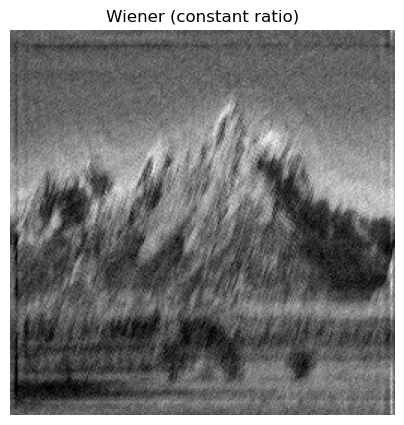

In [4]:
# %%
# ---------- (a) Wiener with CONSTANT RATIO (NSR = sigma_n^2 / sigma_f^2) ----------
def wiener_constant(degraded, Hk, nsr=None, eps=1e-8):
    """
    nsr: noise-to-signal power ratio (scalar). If None, estimate from image variances.
    """
    if nsr is None:
        # estimate signal variance from degraded image after rough deblurring region
        sig_var = float(np.var(degraded))
        # if you know noise sigma, use it (else estimate from smooth background regions)
        noise_var = float(sigma_n**2)  # using synthetic noise setting
        nsr = max(noise_var / (sig_var + 1e-8), 1e-6)
    Gc = fft2c(degraded)
    H2 = (np.abs(Hk)**2)
    W  = np.conj(Hk) / (H2 + nsr + eps)
    Fh = Gc * W
    rec = ifft2c(Fh)
    return np.clip(rec, 0, 255).astype(np.float32), nsr

rest_const, nsr_used = wiener_constant(degraded, Hk, nsr=None)
print(f"Estimated NSR used: {nsr_used:.6f}")
show(rest_const, "Wiener (constant ratio)")


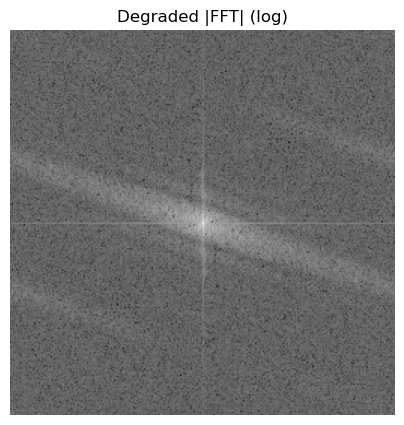

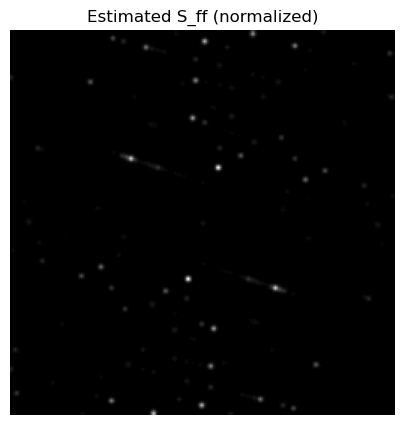

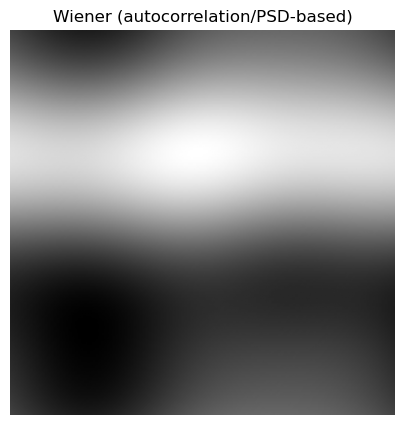

In [5]:
# %%
# ---------- (b) Wiener using AUTOCORRELATION / PSD ESTIMATION ----------
# S_gg (power spectrum of degraded) = |G|^2 ; for white noise S_nn ≈ sigma_n^2 (flat).
# Estimate S_ff via: S_ff ≈ max( (S_gg - S_nn), 0 ) / (|H|^2 + tiny)
# (Relationship S_gg = |H|^2 S_ff + S_nn comes from convolution + additive noise.)
# We build this through the autocorrelation link for clarity: R_xx = IFFT( |X|^2 ), S_xx = FFT(R_xx).

def autocorr2_fft(im):
    """Unbiased 2D autocorrelation via FFT: R = IFFT( |FFT(im)|^2 )."""
    X  = fft2c(im)
    S  = np.abs(X)**2
    R  = ifft2c(S)
    return R

def wiener_autocorr(degraded, Hk, sigma_n, smooth_psd=True, eps=1e-8):
    Gc = fft2c(degraded)

    # Step 1: Estimate S_gg from autocorrelation (for demonstration; it equals |G|^2)
    Rgg = autocorr2_fft(degraded)
    Sgg = np.abs(fft2c(Rgg))  # equals |G|^2 (up to numerical errors)

    # Step 2: Noise PSD (white)
    Snn = (sigma_n**2) * np.ones_like(Sgg, dtype=np.float32)

    # Step 3: Estimate S_ff using S_gg ≈ |H|^2 S_ff + S_nn
    H2  = np.abs(Hk)**2
    Sff = np.maximum(Sgg - Snn, 0.0) / (H2 + eps)

    # Optional gentle smoothing of Sff (robustness)
    if smooth_psd:
        Sff_u8 = cv2.normalize(Sff, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        Sff = cv2.GaussianBlur(Sff_u8, (7,7), 1.2).astype(np.float32)

    # Step 4: Wiener filter using spatially varying Sff & Snn
    W = (np.conj(Hk) * Sff) / (H2 * Sff + Snn + eps)
    Fh = Gc * W
    rec = ifft2c(Fh)
    return np.clip(rec, 0, 255).astype(np.float32), Sff, Snn

rest_auto, Sff_est, Snn_est = wiener_autocorr(degraded, Hk, sigma_n=sigma_n)

show(magspec(fft2c(degraded)), "Degraded |FFT| (log)")
show(cv2.normalize(Sff_est, None, 0, 255, cv2.NORM_MINMAX), "Estimated S_ff (normalized)", cmap="gray")
show(rest_auto, "Wiener (autocorrelation/PSD-based)")


PSNR Blurred            : 18.87 dB
PSNR Degraded (blur+noise): 18.70 dB
PSNR Wiener (constant)  : 18.19 dB
PSNR Wiener (autocorr)  : 7.56 dB


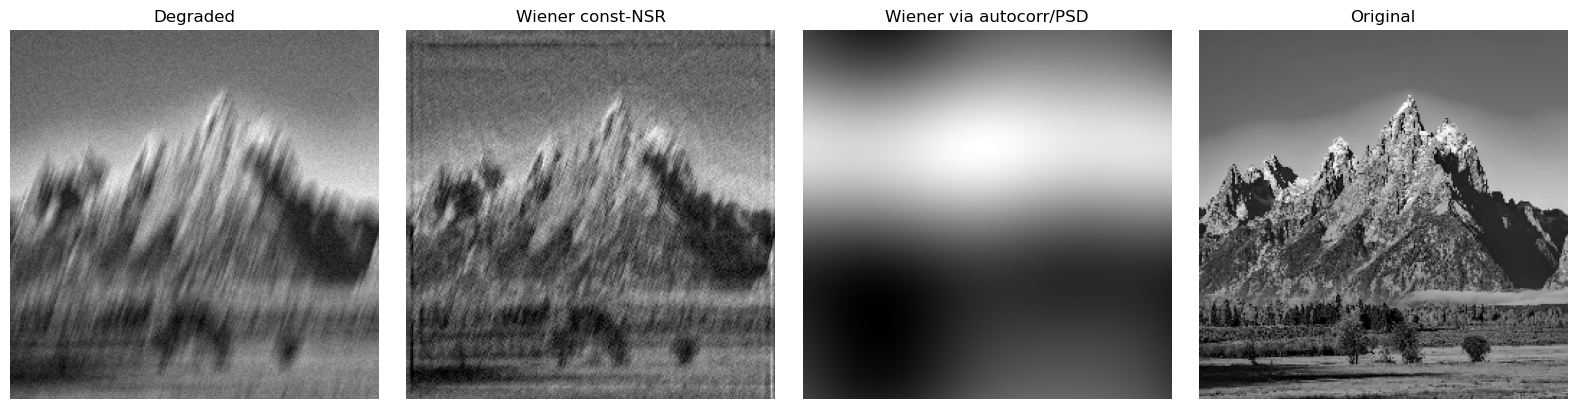

In [6]:
# %%
# ---------- Quantitative comparison ----------
def psnr(ref, test):
    ref = ref.astype(np.float32); test = test.astype(np.float32)
    mse = np.mean((ref - test)**2)
    return 99. if mse < 1e-12 else 10*np.log10((255**2)/mse)

print(f"PSNR Blurred            : {psnr(orig, blurred):.2f} dB")
print(f"PSNR Degraded (blur+noise): {psnr(orig, degraded):.2f} dB")
print(f"PSNR Wiener (constant)  : {psnr(orig, rest_const):.2f} dB")
print(f"PSNR Wiener (autocorr)  : {psnr(orig, rest_auto):.2f} dB")

# Side-by-side
fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(degraded, cmap="gray");   ax[0].set_title("Degraded"); ax[0].axis("off")
ax[1].imshow(rest_const, cmap="gray"); ax[1].set_title("Wiener const-NSR"); ax[1].axis("off")
ax[2].imshow(rest_auto, cmap="gray");  ax[2].set_title("Wiener via autocorr/PSD"); ax[2].axis("off")
ax[3].imshow(orig, cmap="gray");       ax[3].set_title("Original"); ax[3].axis("off")
plt.tight_layout(); plt.show()
